<a href="https://colab.research.google.com/github/sampathmurala/AIMLOps/blob/develop/M5_NB_MiniProject_1_ResumeClassification_Using_NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project 1: Resume Classification

## Learning Objectives

At the end of the mini-project, you will be able to :

* perform data preprocessing, EDA and feature extraction on the Resume dataset
* perform multinomial Naive Bayes classification on the Resume dataset

### Dataset description

The data is in CSV format, with two features: Category, and Resume.

**Category** -  Industry sector to which the resume belongs to, and

**Resume** - The complete CV (text) of the candidate.

##  Grading = 10 Points

## Information

Companies often receive thousands of resumes for each job posting and employ dedicated screening officers to screen qualified candidates. Finding suitable candidates for an open role from a database of 1000s of resumes can be a tough task. Automated resume categorization can speeden the candidate selection process. Such automation can really ease the tedious process of fair screening and shortlisting the right candidates and aid quick decision making.

To learn more about this, click [here](https://www.sciencedirect.com/science/article/pii/S187705092030750X).

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix
from pandas.plotting import scatter_matrix
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.gridspec import GridSpec
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Downloading the data

In [3]:
#@title Download the dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/UpdatedResumeDataSet.csv
print("Data Downloaded Successfuly!!")
!ls | grep '.csv'

Data Downloaded Successfuly!!
UpdatedResumeDataSet.csv


**Exercise 1: Read the UpdatedResumeDataset.csv dataset [0.5 Mark]**

**Hint:** pd.read_csv()

In [4]:
# read the dataset
df = pd.read_csv("/content/UpdatedResumeDataSet.csv")
df.shape

(962, 2)

In [5]:
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


### Pre-processing and EDA

**Exercise 2: Display  all the categories of resumes and their counts in the dataset [0.5 Mark]**



In [6]:
# Display the distinct categories of resume
categories = df['Category'].unique()
print(len(categories), categories)

25 ['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [7]:
# Display the distinct categories of resume and the number of records belonging to each category
df.Category.value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

**Exercise 3: Create the count plot of different categories [0.5 Mark]**

**Hint:** Use `sns.countplot()`

<Axes: xlabel='count', ylabel='Category'>

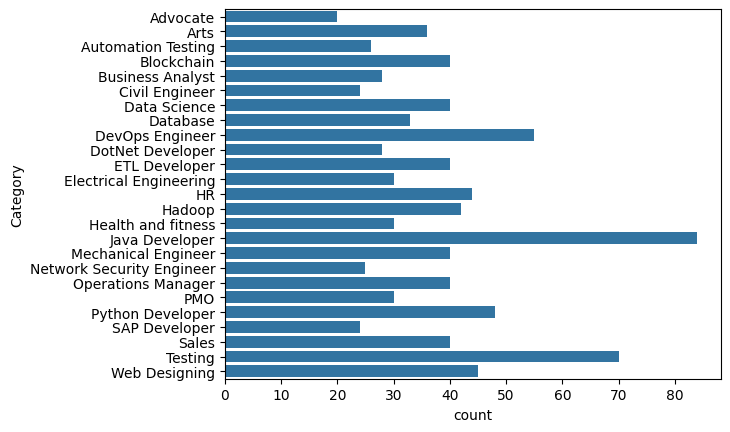

In [8]:
sns.countplot(df, y="Category",  order=sorted(categories))

**Exercise 4: Create a pie plot depicting the percentage of resume distributions category-wise [0.5 mark]**

**Hint:** Use [plt.pie()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html) and [plt.get_cmap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for color mapping the pie chart.

In [ ]:
from matplotlib import colormaps
list(colormaps)

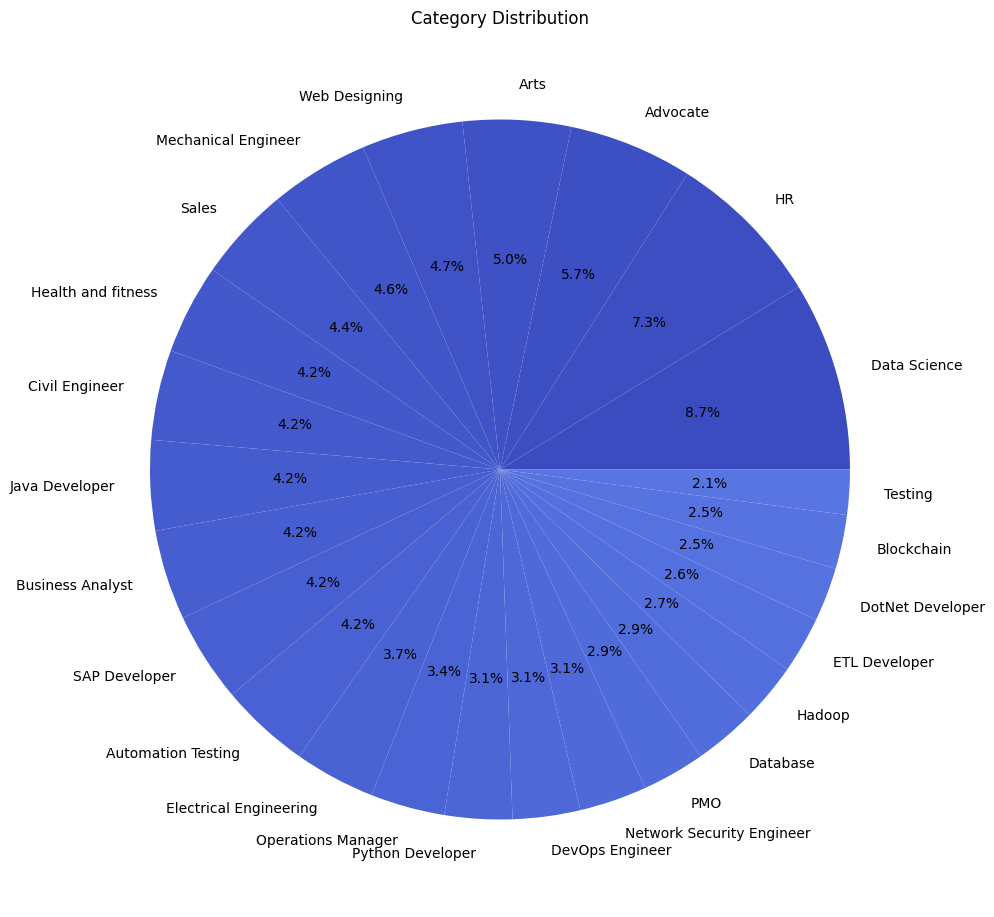

In [10]:
targetCounts = df['Category'].value_counts()
targetLabels  = df['Category'].unique()

# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)

#to display pie chart with color coding (eg. `coolwarm`)
cmap = plt.get_cmap("coolwarm")
colors=cmap(range(len(targetCounts)))


# Plotting the pie chart
plt.subplot(the_grid[0, 1], title='Category Distribution')
plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', colors=colors)
plt.show()

**Exercise 5: Convert all the `Resume` text to lower case [0.5 Mark]**




In [11]:
# Convert all characters to lowercase
df['Resume'] = df['Resume'].str.lower()
df['Resume']

0      skills * programming languages: python (pandas...
1      education details \r\nmay 2013 to may 2017 b.e...
2      areas of interest deep learning, control syste...
3      skills â¢ r â¢ python â¢ sap hana â¢ table...
4      education details \r\n mca   ymcaust,  faridab...
                             ...                        
957    computer skills: â¢ proficient in ms office (...
958    â willingness to accept the challenges. â ...
959    personal skills â¢ quick learner, â¢ eagerne...
960    computer skills & software knowledge ms-power ...
961    skill set os windows xp/7/8/8.1/10 database my...
Name: Resume, Length: 962, dtype: object

### Cleaning resumes' text data

**Exercise 6: Define a function to clean the resume text [2 Mark]**

In the text there are special characters, urls, hashtags, mentions, etc. Remove the following:  

* URLs: For reference click [here](https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python)
* RT | cc: For reference click [here](https://www.machinelearningplus.com/python/python-regex-tutorial-examples/)
* Hashtags, # and Mentions, @
* punctuations
* extra whitespace

PS: Use the provided reference similarly for removing any other such elements.

After cleaning as above, store the Resume Text in a separate column (New Feature).


In [12]:
import re
def cleanResume(resumeText):
    # Remove URLs, RT, and cc
    text = re.sub(r"http[s]?://\S+|RT|cc:", "", resumeText)
    # Remove hashtags and mentions
    text = re.sub(r"#\S+|@\S+", "", text)
    # Remove punctuations
    text = re.sub(r"[^\w\s]", "", text) #all punctuation marks by negating word characters and space characters
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [13]:
# Example usage
text = "This is a resume with some special characters, http://www.example.com, #hashtag, @mention, and punctuations! It also has extra     whitespace."
cleaned_text = cleanResume(text)
print(cleaned_text)

This is a resume with some special characters and punctuations It also has extra whitespace


In [15]:
df

,Category,Resume,cleaned_resume
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 be uitr...
2,Data Science,"areas of interest deep learning, control syste...",areas of interest deep learning control system...
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills â r â python â sap hana â tableau â sap...
4,Data Science,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...
...,...,...,...
957,Testing,computer skills: â¢ proficient in ms office (...,computer skills â proficient in ms office word...
958,Testing,â willingness to accept the challenges. â ...,â willingness to accept the challenges â posit...
959,Testing,"personal skills â¢ quick learner, â¢ eagerne...",personal skills â quick learner â eagerness to...
960,Testing,computer skills & software knowledge ms-power ...,computer skills software knowledge mspower poi...


In [16]:
sent_lens = []
for i in df.cleaned_resume:
    length = len(i.split())
    sent_lens.append(length)

print(len(sent_lens))
print(max(sent_lens))
print(sent_lens)

962
2110
[636, 151, 254, 968, 61, 96, 226, 1121, 239, 666, 636, 151, 254, 968, 61, 96, 226, 1121, 239, 666, 636, 151, 254, 968, 61, 96, 226, 1121, 239, 666, 636, 151, 254, 968, 61, 96, 226, 1121, 239, 666, 53, 354, 21, 24, 24, 16, 17, 155, 80, 128, 106, 53, 354, 21, 24, 24, 16, 17, 155, 80, 128, 106, 53, 354, 21, 24, 24, 16, 17, 155, 80, 128, 106, 53, 354, 21, 24, 24, 16, 17, 155, 80, 128, 106, 252, 65, 21, 118, 401, 104, 64, 161, 85, 45, 252, 65, 21, 118, 401, 104, 64, 161, 85, 45, 222, 131, 1181, 58, 91, 145, 222, 131, 1181, 58, 91, 145, 222, 131, 1181, 58, 91, 145, 222, 131, 1181, 58, 91, 145, 222, 131, 1181, 58, 91, 145, 222, 131, 1181, 58, 91, 145, 488, 466, 488, 86, 440, 488, 466, 488, 86, 440, 488, 466, 488, 86, 440, 488, 466, 488, 86, 440, 488, 466, 488, 86, 440, 488, 466, 488, 86, 440, 488, 466, 488, 86, 440, 488, 466, 488, 86, 440, 488, 466, 488, 86, 440, 1300, 238, 75, 298, 159, 1300, 238, 75, 298, 159, 1300, 238, 75, 298, 159, 1300, 238, 75, 298, 159, 1300, 238, 75, 298, 15

### Stopwords removal

The stopwords, for example, `and, the, was, and so forth` etc. appear very frequently in the text and are not helpful in the predictive process. Therefore these are usually removed for text analytics and text classification purposes.

1. Tokenize the input words into individual tokens and store it in an array
2. Using `nltk.corpus.stopwords`, remove the stopwords

Hint: See Module 1 - Assignment 4 'Text Classification using Naive Bayes'


**Exercise 7: Use `nltk` package to find the most common words from the `cleaned resume` column [2 Marks]**

**Hint:**
* Use `nltk.FreqDist`


In [24]:
# Combine all cleaned text into a single string
all_text = " ".join(df["cleaned_resume"])

# Tokenize the text into words
tokens = nltk.word_tokenize(all_text.lower())

In [89]:
#print the stopwords in english language
stopword_list = nltk.corpus.stopwords.words('english')
updated_stopword_list = [word for word in stopword_list if word != 'not' and not word.endswith("n't")]
print(len(updated_stopword_list), updated_stopword_list)


# Remove stop words
tokens = [token for token in tokens if token not in updated_stopword_list]

160 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too

In [91]:
# apply function on review column
df['cleaned_resume'] = df['cleaned_resume'].apply(remove_stopwords)

In [26]:
# most common words
#Create a FreqDist object from the combined cleaned text
fdist = nltk.FreqDist(tokens)

# Find the most common words
most_common = fdist.most_common(10)  # Adjust the number as needed

print("Most common words (excluding stop words):")
for word, count in most_common:
  print(f"{word}: {count}")

Most common words (excluding stop words):
â: 15153
exprience: 3829
company: 3526
project: 3353
months: 3283
description: 3122
details: 3096
data: 2125
management: 1969
team: 1918


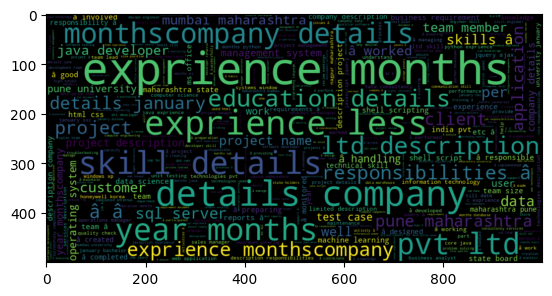

In [29]:
# YOUR CODE HERE to show the most common word using WordCloud
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words = WC.generate(all_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.show()

**Exercise 8: Convert the categorical variable `Category` to a numerical feature and make a different column, which can be treated as the target variable [0.5 Mark]**

**Hint:** Use [`sklearn.preprocessing.LabelEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) method

In [46]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Category_Encoded'] = le.fit_transform(df.Category)

In [47]:
list(le.classes_)

['Advocate',
 'Arts',
 'Automation Testing',
 'Blockchain',
 'Business Analyst',
 'Civil Engineer',
 'Data Science',
 'Database',
 'DevOps Engineer',
 'DotNet Developer',
 'ETL Developer',
 'Electrical Engineering',
 'HR',
 'Hadoop',
 'Health and fitness',
 'Java Developer',
 'Mechanical Engineer',
 'Network Security Engineer',
 'Operations Manager',
 'PMO',
 'Python Developer',
 'SAP Developer',
 'Sales',
 'Testing',
 'Web Designing']

In [48]:
# Print the DataFrame
df

,Category,Resume,cleaned_resume,Category_Encoded
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...,6
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 be uitr...,6
2,Data Science,"areas of interest deep learning, control syste...",areas of interest deep learning control system...,6
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills â r â python â sap hana â tableau â sap...,6
4,Data Science,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...,6
...,...,...,...,...
957,Testing,computer skills: â¢ proficient in ms office (...,computer skills â proficient in ms office word...,23
958,Testing,â willingness to accept the challenges. â ...,â willingness to accept the challenges â posit...,23
959,Testing,"personal skills â¢ quick learner, â¢ eagerne...",personal skills â quick learner â eagerness to...,23
960,Testing,computer skills & software knowledge ms-power ...,computer skills software knowledge mspower poi...,23


from matplotlib import pyplot as plt
df['Category_Encoded'].plot(kind='hist', bins=20, title='Category_Encoded')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Category_Encoded'].plot(kind='line', figsize=(8, 4), title='Category_Encoded')
plt.gca().spines[['top', 'right']].set_visible(False)

### Feature Extraction

**Exercise 9: Convert the text to feature vectors by applying `tfidf vectorizer` to the Label encoded category made above [2 Marks]**

`TF-IDF`will tokenize documents, learn the vocabulary, inverse document frequency weightings, and allow you to encode new documents

**Hint:** Use [`TfidfVectorizer()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).



In [75]:
# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.8, use_idf = True, ngram_range=(1,2))

# Fit the vectorizer on the combined text data
features = vectorizer.fit_transform(df.cleaned_resume)

# Print the TF-IDF features
print(features.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.07412768 0.         ... 0.30468524 0.06027318 0.        ]
 [0.         0.         0.         ... 0.29776326 0.04207419 0.        ]
 ...
 [0.04349476 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.13949223 0.         0.0542773  ... 0.         0.         0.        ]]


## Naive Bayes Classifier

**Exercise 10: Split the data into train and test sets. Apply Naive Bayes Classifier (MultinomialNB) and evaluate the model predictions [1 mark]**

**Hint:** Use Vectorized features made above as X and Labelled category as y.

In [76]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, df['Category_Encoded'], test_size=0.2, random_state=42)

# Create the Multinomial Naive Bayes model
clf = MultinomialNB()

# fitting the NaiveBayes for tfidf features on the training data
mnb_tfidf = clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)
print('predictions for tf-idf :', y_pred)

# Evaluate model performance

# accuracy score for tf-idf
mnb_tfidf_score = accuracy_score(y_test, y_pred)
print("mnb_tfidf_score :", mnb_tfidf_score)

predictions for tf-idf : [15 15 15 13 14 17 16 23 15 22 13 12 16 23 20 16  6  4 10  9 19  1 10 23
 23  6 22 22 23 12 18  1  8 24 11 23  7 12 24  8 18  6  8 19 24 23  1 18
 15  4 15 22 11 16 15 13  1 19 18 12 22 22 20 24 13 18 12 15 15 20 10  8
 15 19 17  6 22 17 16 14 15 11 11  8 15  3 19  8 15  2  9 10 23 23 15 20
 23 15 18 12  7 16  8 14 18  3  1 19  1 22 15 18  8  2 13 18 23 10 23 23
 11 15 12  3 23  3  7 12 19  8 20 19  3 15 15 19  1 23 19 18 20 15 16  7
  7  8 15 18  1 15 13 20  7  4 18 11 23 15 18 12 20 22 18 13  8 23  4 12
 24 16 15 22  8 22  3 16 23 23 12  7 16 18 23  3 18  8 23 23 20  6  6  7
 23]
mnb_tfidf_score : 0.8134715025906736


In [86]:
# confusion matrix for tf-idf
# print(y_test, y_pred)
cm_tfidf = confusion_matrix(y_test,y_pred, labels=df.Category_Encoded)
print('confusion matrix for tf-idf :\n', cm_tfidf)

confusion matrix for tf-idf :
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0 16]]


## Optional: Create a Gradio based web interface to test and display the model predictions

In [87]:
!pip -q install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 9.9 MB/s eta 0:00:00


In [88]:
import gradio

In [92]:
# removing the stopwords
def remove_stopwords(text):
    # splitting strings into tokens (list of words)
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in updated_stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [93]:
# Function for preprocessing of text

def preprocess_text(text):

    cleaned_text = cleanResume(text)
    text = remove_stopwords(cleaned_text)

    return text

In [145]:
# Function to predict label for a review

def predict_review_label(text):

    processed_text = preprocess_text(text)

    review = vectorizer.transform([processed_text])
    pred = mnb_tfidf.predict(review)

    return le.inverse_transform([pred[0]])[0]

In [146]:
import random
choice = random.choice(df['Resume'])
print(predict_review_label(choice))

Sales


In [132]:
# Dropdown choices
in_vectorizer_dropdown = gradio.Dropdown(['None', 'TFIDFVectorizer'], type="value", label='Choose a Method to Vectorize')

# Input from user
in_review = gradio.Textbox(lines=2, placeholder=None, value="resume", label='Enter Resume Text')

In [133]:
# Output prediction
out_label = gradio.Textbox(type="text", label='Predicted Resume Label')

In [147]:
# Gradio interface to generate UI link

iface = gradio.Interface(fn = predict_review_label,
                         inputs = [in_review],
                         outputs = [out_label])

iface.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://948276db6b6fe667ba.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


**Report Analysis**
- Which method(s), other than TF-IDF could be used for text to vector conversion?
- Discuss about the `alpha`, `class_prior` and `fit_prior` parameters in sklearn `MultinomialNB`


Dataset Source Reference: [Resume dataset](https://www.kaggle.com/gauravduttakiit/resume-dataset/download)